In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn, optim
from torch.utils.data import Dataset ,DataLoader
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_DIR='/content/drive/MyDrive/ml-latest-small'
dfm=pd.read_csv(DATA_DIR+'/movies.csv')
df=pd.read_csv(DATA_DIR+'/ratings.csv')
df=df.merge(dfm,on='movieId', how='left')
df=df.sort_values(['userId','timestamp'] , ascending=[True,True]).reset_index(drop=True)
df.head(3)

,userId,movieId,rating,timestamp,title,genres
0,1,804,4.0,964980499,She's the One (1996),Comedy|Romance
1,1,1210,5.0,964980499,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
2,1,2018,5.0,964980523,Bambi (1942),Animation|Children|Drama


In [ ]:
d = defaultdict(LabelEncoder)
cols_cat = ['userId', 'movieId']
for c in cols_cat:
    d[c].fit(df[c].unique())
    df[c] = d[c].transform(df[c])
    print(f'# unique {c}: {len(d[c].classes_)}')

min_num_ratings = df.groupby(['userId'])['userId'].transform(len).min()
print(f'Min # of ratings per user: {min_num_ratings}')
print(f'Min/Max rating: {df.rating.min()}/{df.rating.max()}, df.shape: {df.shape}')
df.head(3)

# unique userId: 610
# unique movieId: 9724
Min # of ratings per user: 20
Min/Max rating: 0.5/5.0, df.shape: (100836, 6)


,userId,movieId,rating,timestamp,title,genres
0,0,632,4.0,964980499,She's the One (1996),Comedy|Romance
1,0,910,5.0,964980499,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
2,0,1492,5.0,964980523,Bambi (1942),Animation|Children|Drama


In [ ]:
df_train = df.groupby('userId').head(-5).reset_index(drop=True)
df_val = df.groupby('userId').tail(5).reset_index(drop=True)
print(df_train.shape, df_val.shape)

(97786, 6) (3050, 6)


In [ ]:
class MovieDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df[['userId', 'movieId', 'rating']]
        self.x_user_movie = list(zip(df.userId.values, df.movieId.values))
        self.y_rating = self.df.rating.values
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        return self.x_user_movie[idx], self.y_rating[idx]

In [ ]:
BS = 8192
ds_train = MovieDataset(df_train)
ds_val = MovieDataset(df_val)
dl_train = DataLoader(ds_train, BS, shuffle=True, num_workers=4)
dl_val = DataLoader(ds_val, BS, shuffle=True, num_workers=4)

xb, yb = next(iter(dl_train))
print(xb)
print(yb)

[tensor([523, 291,  67,  ..., 473,  17, 400]), tensor([ 418, 2078, 1661,  ..., 5150, 5380, 3867])]
tensor([4., 3., 2.,  ..., 4., 3., 4.], dtype=torch.float64)


In [ ]:
class MF(nn.Module):
    """ Matrix factorization model simple """
    def __init__(self, num_users, num_items, emb_dim):
        super().__init__()
        self.user_emb = nn.Embedding(num_embeddings=num_users, embedding_dim=emb_dim)
        self.item_emb = nn.Embedding(num_embeddings=num_items, embedding_dim=emb_dim)
    def forward(self, user, item):
        user_emb = self.user_emb(user)
        item_emb = self.item_emb(item)
        element_product = (user_emb*item_emb).sum(1)
        return element_product

In [ ]:
n_users = len(df.userId.unique())
n_items = len(df.movieId.unique())
mdl = MF(n_users, n_items, emb_dim=32)
mdl.to(device)
print(mdl)

MF(
  (user_emb): Embedding(610, 32)
  (item_emb): Embedding(9724, 32)
)


In [ ]:
LR = 0.2
NUM_EPOCHS = 10

opt = optim.AdamW(mdl.parameters(), lr=LR)
loss_fn = nn.MSELoss()
epoch_train_losses, epoch_val_losses = [], []

for i in range(NUM_EPOCHS):
    train_losses, val_losses = [], []
    mdl.train()
    for xb,yb in dl_train:
        xUser = xb[0].to(device, dtype=torch.long)
        xItem = xb[1].to(device, dtype=torch.long)
        yRatings = yb.to(device, dtype=torch.float)
        preds = mdl(xUser, xItem)
        loss = loss_fn(preds, yRatings)
        train_losses.append(loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()
    mdl.eval()
    for xb,yb in dl_val:
        xUser = xb[0].to(device, dtype=torch.long)
        xItem = xb[1].to(device, dtype=torch.long)
        yRatings = yb.to(device, dtype=torch.float)
        preds = mdl(xUser, xItem)
        loss = loss_fn(preds, yRatings)
        val_losses.append(loss.item())
    # Start logging
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_losses.append(epoch_train_loss)
    epoch_val_losses.append(epoch_val_loss)
    print(f'Epoch: {i}, Train Loss: {epoch_train_loss:0.1f}, Val Loss:{epoch_val_loss:0.1f}')

Epoch: 0, Train Loss: 25.5, Val Loss:21.9
Epoch: 1, Train Loss: 7.2, Val Loss:11.2
Epoch: 2, Train Loss: 3.2, Val Loss:6.4
Epoch: 3, Train Loss: 1.6, Val Loss:4.2
Epoch: 4, Train Loss: 1.0, Val Loss:3.6
Epoch: 5, Train Loss: 0.7, Val Loss:3.0
Epoch: 6, Train Loss: 0.6, Val Loss:2.8
Epoch: 7, Train Loss: 0.5, Val Loss:2.8
Epoch: 8, Train Loss: 0.4, Val Loss:2.7
Epoch: 9, Train Loss: 0.4, Val Loss:2.7


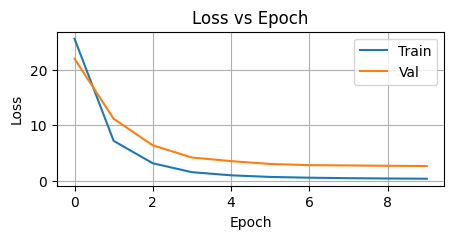

In [ ]:
plt.figure(figsize=(5,2))
plt.plot(epoch_train_losses, label='Train')
plt.plot(epoch_val_losses, label='Val')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend();

In [ ]:
user_emb_min_w = mdl.user_emb.weight.min().item()
user_emb_max_w = mdl.user_emb.weight.max().item()
item_emb_min_w = mdl.item_emb.weight.min().item()
item_emb_max_w = mdl.item_emb.weight.max().item()
print(f'Emb user min/max w: {user_emb_min_w:0.3f} / {user_emb_max_w:0.3f}')
print(f'Emb item min/max w: {item_emb_min_w:0.3f} / {item_emb_max_w:0.3f}')
print(f'Preds min/max: {preds.min().item():0.2f} / {preds.max().item():0.2f}')
print(f'Rating min/max: {yRatings.min().item():0.2f} / {yRatings.max().item():0.2f}')
print(preds.detach().cpu().numpy()[:6])
print(yRatings.detach().cpu().numpy()[:6])

Emb user min/max w: -1.771 / 2.474
Emb item min/max w: -4.844 / 4.820
Preds min/max: -3.85 / 8.15
Rating min/max: 0.50 / 5.00
[3.7080448 1.547909  1.5862435 3.5353854 4.1216664 2.580208 ]
[5. 3. 3. 1. 3. 2.]
